## Load Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier  #Random Forest algorithm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import cv2
from PIL import Image
from skimage.feature import greycomatrix, greycoprops
import skimage.measure
%matplotlib inline

## Load Dataset

In [2]:
df = pd.read_csv("Image_Dataset_Color_Texture_Shape_Features.csv")

## Display Image

In [3]:
def display(img):
    plt.imshow (img, interpolation = 'nearest')
    _ = plt.axis(False)
    print("Image Shape: ", img.shape)

## Seperate the target and independant variables

In [4]:
df_X = df.iloc[:, 0:-1]
df_Y = df.iloc[:, -1]

In [5]:
df_X.shape

(3353, 73)

## Standard Scaler

## Principle Component Analysis

In [6]:
from sklearn.decomposition import PCA
pca=PCA(n_components=10)
df_X=pca.fit_transform(df_X)

In [7]:
df_X.shape

(3353, 10)

In [8]:
df_X[-3:-1]

array([[ 1190.60620979, -2196.15384331,  -802.26639621,  2088.32274362,
          201.18414084,  -973.60996242,   351.97988388,  -188.85891632,
           99.7496689 ,    55.90183578],
       [-5330.61362049,  -148.84538308, -1344.57551922, -1438.0892262 ,
        -1109.30367893,  -458.65332534,  -206.32908831,  -721.77762889,
         -235.82493678,  -108.23820918]])

## Stratified K-Fold Validation

## Train Test Split Model

In [9]:
#Split the dataset
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.2, random_state=0)

## Train Random Forest Model

In [10]:
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train,y_train)

RandomForestClassifier()

In [11]:
y_pred = model.predict(X_train)

## Cross Validation Score

In [12]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(model, df_X, df_Y)
print(score)

[1. 1. 1. 1. 1.]


## Accuracy of Model

In [13]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_train, y_pred))

1.0


## Classification Report

In [14]:
pd.DataFrame(classification_report(y_train, y_pred, output_dict = True)).T

,precision,recall,f1-score,support
Apple,1.0,1.0,1.0,397.0
Banana,1.0,1.0,1.0,397.0
Grape,1.0,1.0,1.0,382.0
Limes,1.0,1.0,1.0,373.0
Orange,1.0,1.0,1.0,373.0
Pear,1.0,1.0,1.0,380.0
Strawberry,1.0,1.0,1.0,380.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,2682.0
weighted avg,1.0,1.0,1.0,2682.0


## Confusion matrix

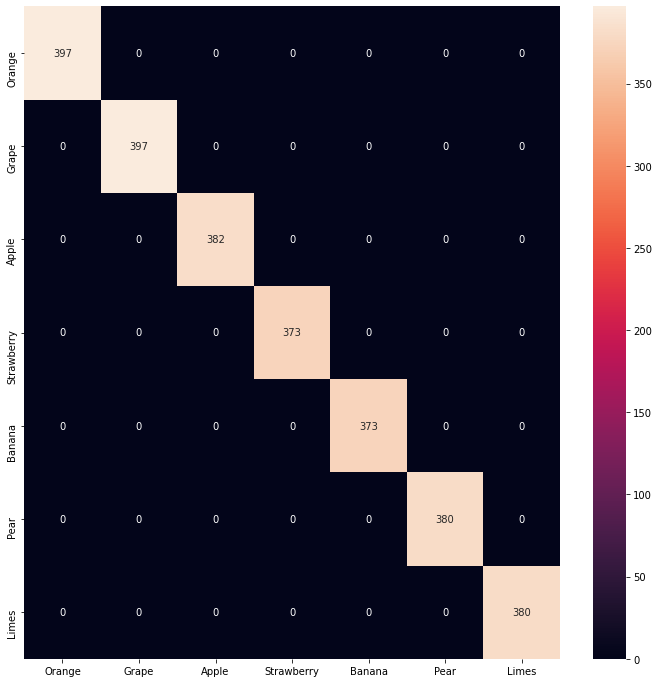

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_train, y_pred), index = df_Y.unique(), columns = df_Y.unique())
fig = plt.figure(figsize=(12,12))
sns.heatmap(confusion_matrix_df,annot=True, fmt='g')
plt.show()

## Train Support Vector Machine

In [16]:
from sklearn import svm
model = svm.SVC(decision_function_shape='ovo')
model.fit(X_train,y_train)

SVC(decision_function_shape='ovo')

In [17]:
y_pred = model.predict(X_test)

In [18]:
pd.DataFrame(classification_report(y_test, y_pred, output_dict = True)).T

,precision,recall,f1-score,support
Apple,1.0,1.0,1.0,82.0
Banana,1.0,1.0,1.0,82.0
Grape,1.0,1.0,1.0,97.0
Limes,1.0,1.0,1.0,106.0
Orange,1.0,1.0,1.0,106.0
Pear,1.0,1.0,1.0,99.0
Strawberry,1.0,1.0,1.0,99.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,671.0
weighted avg,1.0,1.0,1.0,671.0


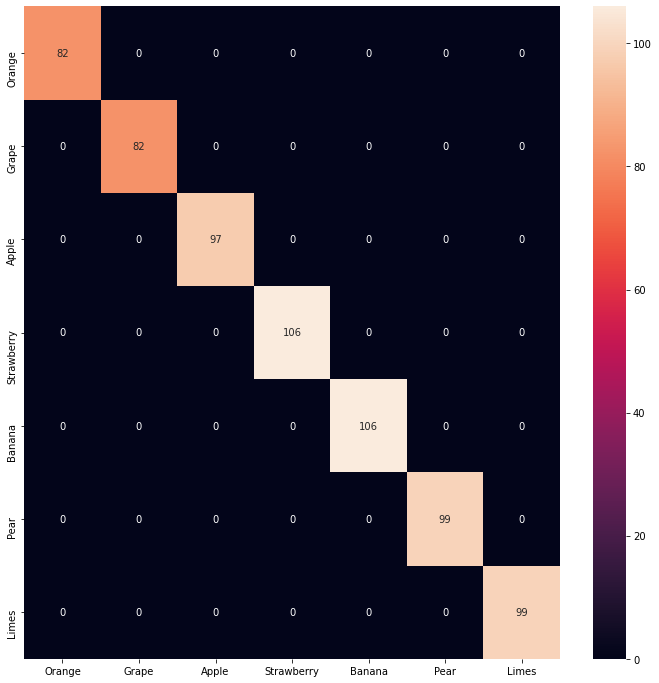

In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred), index = df_Y.unique(), columns = df_Y.unique())
fig = plt.figure(figsize=(12,12))
sns.heatmap(confusion_matrix_df,annot=True, fmt='g')
plt.show()

In [20]:
print(y_pred[6], y_train[6])

Limes Apple


## Test Image

### Conversion Function

In [21]:
def convert_val_to_rgb(x):
    if x >= 0 and x < 64:
        return "00"
    elif x >= 64 and x < 128:
        return "55"
    elif x >= 128 and x < 192:
        return "AA"
    else:
        return "FF"
    
def convert_val_to_bin(x):
    if x >= 0 and x < 64:
        return 0
    elif x >= 64 and x < 128:
        return 85
    elif x >= 128 and x < 192:
        return 170
    else:
        return 255

### Pipeline Color Features

In [22]:
def pipeline_color(cv_img):
    img_arr = np.array(cv_img)
    img_flatten = img_arr.reshape(1, -1).T
    img_squeeze = np.squeeze(img_flatten)
    img_convert = np.vectorize(convert_val_to_rgb)(img_squeeze)
    img_2d_arr = img_convert.reshape(-1, 3)
    img_list_arr = img_2d_arr.tolist()
    convert_to_str = lambda x:"#"+"".join(list(map(str, x)))
    img_str_arr = [convert_to_str(x) for x in img_list_arr]
    new_arr = np.array(img_str_arr)
    tmp_dict = {a:b for (a,b) in zip(np.unique(new_arr, return_counts=True)[0], np.unique(new_arr, return_counts=True)[1])}
    return tmp_dict

### Pipeline Texture Features

In [23]:
def pipeline_texture(img_gray):
    tmp_dict = {}
    tmp_dict["Mean"] = np.mean(img_gray)
    tmp_dict["Variance"] = np.var(img_gray)
    tmp_dict["Entropy"] = skimage.measure.shannon_entropy(img_gray)
    glcm = greycomatrix(img_gray, [2], [0], 256, symmetric = True, normed = True)
    tmp_dict["Contrast"] = greycoprops(glcm, prop="contrast").item()
    tmp_dict["Homogeneity"] = greycoprops(glcm, prop="homogeneity").item()
    tmp_dict["Correlation"] = greycoprops(glcm, prop="correlation").item()
    tmp_dict["Energy"] = greycoprops(glcm, prop="energy").item()
    return tmp_dict

### Pipeline Shape Features

In [24]:
def pipeline_shape(img_gray):
    # Apply Gaussian Blur to Image
    img_blur = cv2.GaussianBlur(img_gray, (7,7), 1)

    # Canny Edge Detection
    img_canny = cv2.Canny(img_blur, 50, 150)

    # Edge Detector
    kernel = np.ones((5, 5), dtype = np.uint8)
    img_dilate = cv2.dilate(img_canny, kernel, iterations = 1)

    contours, hier = cv2.findContours(img_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    area, peri = 0, 0
    for cnt in contours:
        area = cv2.contourArea(cnt)
        peri = cv2.arcLength(cnt, True)
    tmp_dict = {}
    tmp_dict["Area"] = area
    tmp_dict["Perimeter"] = peri
    return tmp_dict

### Pipeline Final

In [25]:
def pipeline_final(img_path, w = 100, h = 100):
    final_dict = {}
    
    cv_img = cv2.imread(img_path)
    
    # Resize Image
    cv_img = cv2.resize(cv_img, (w,h),interpolation = cv2.INTER_AREA)
    
    # Convert Image from BGR to RGB
    cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    
    # Convert Image to Gray Image
    img_gray = cv2.cvtColor(cv_img, cv2.COLOR_RGB2GRAY)
    
    # Get Color Features
    color_feature_dict = pipeline_color(cv_img)
    final_dict.update(color_feature_dict)

    # Get Texture Features
    texture_feature_dict = pipeline_texture(img_gray)
    final_dict.update(texture_feature_dict)

    # Get Shape Features
    shape_feature_dict = pipeline_shape(img_gray)
    final_dict.update(shape_feature_dict)
    
    return final_dict

In [26]:
feature_arr = []
cc = ["00", "55", "AA", "FF"]
for i in range(4):
    for j in range(4):
        for k in range(4):
            feature_arr.append(f"#{cc[i]}{cc[j]}{cc[k]}")
feature_arr += ["Mean", "Variance", "Entropy", "Contrast", "Homogeneity", "Correlation", "Energy","Area", "Perimeter"]

Image Shape:  (225, 225, 3)


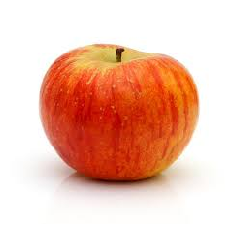

In [27]:
img_path = "Test_Images/apple2.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
display(img)

In [28]:
final_df = pd.DataFrame(columns = feature_arr)
final_dict = pipeline_final(img_path)
final_df = final_df.append(final_dict, ignore_index = True)
final_df.fillna(0, inplace=True)

In [29]:
final_df

,#000000,#000055,#0000AA,#0000FF,#005500,#005555,#0055AA,#0055FF,#00AA00,#00AA55,...,#FFFFFF,Mean,Variance,Entropy,Contrast,Homogeneity,Correlation,Energy,Area,Perimeter
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5952.0,197.9955,4846.10168,5.443908,279.338367,0.485547,0.971364,0.332079,4361.0,254.16652


In [30]:
final_df.shape

(1, 73)

In [31]:
df_X = df.iloc[:, 0:-1]
df_X = df_X.append(final_dict, ignore_index = True)
df_X.fillna(0, inplace=True)

In [32]:
df_X.shape

(3354, 73)

In [36]:
pca=PCA(n_components=10)
pred_x=pca.fit_transform(df_X)
pred = np.array([pred_x[-1]])

In [37]:
pred

array([[  568.44866496,  2263.72248265,  2224.75909301,  1220.90998028,
         -388.15639548,   236.34450385, -1134.92633643,   711.12537137,
         -659.52331519,  -457.93173816]])

In [38]:
pred_label = model.predict(pred)

In [39]:
pred_label

array(['Banana'], dtype=object)